In [8]:
# Load packages
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import numpy as np

plt.rcParams["figure.figsize"] = (16, 9)  # Figure size and width

# Load datasets
m4_data = pd.read_csv("/home/sscf/wqu_mscfe/Financial Econometrics/M4/M4. goog_eur_10.csv", delimiter="\t")
dxyr_data = pd.read_csv("/home/sscf/wqu_mscfe/Financial Econometrics/M4/M4. dxy_r_data.csv", delimiter="\t")
m4_data = m4_data.loc[:, ["Date", "Year", "GOOGLE", "Volume", "EURUSD", "UST10Y"]]

# Convert date variable to date format
m4_data["Date2"] = pd.to_datetime(m4_data["Date"], format="%m/%d/%Y")
dxyr_data["Date2"] = pd.to_datetime(dxyr_data["Date"], format="%m/%d/%Y")

# Selecting columns and setting index
goog = m4_data.loc[:, ["Date2", "GOOGLE"]].set_index("Date2")
ust10 = m4_data.loc[:, ["Date2", "UST10Y"]].set_index("Date2")
dxy = dxyr_data[["Date2", "DXY_R"]].set_index("Date2")

print(goog.head())
print(ust10.head())
print(dxy.head())

                GOOGLE
Date2                 
2016-01-04  741.840027
2016-01-05  742.580017
2016-01-06  743.619995
2016-01-07  726.390015
2016-01-08  714.469971
            UST10Y
Date2             
2016-01-04   2.245
2016-01-05   2.248
2016-01-06   2.177
2016-01-07   2.153
2016-01-08   2.130
               DXY_R
Date2               
2016-01-05  0.005361
2016-01-06 -0.002213
2016-01-07 -0.009679
2016-01-08  0.003258
2016-01-11  0.001928


### **1.1 Remove Trend with a Trend Variable**

In [9]:
# Detrend
timeTrend = np.linspace(1, len(goog.GOOGLE), len(goog.GOOGLE))
print("Before constant:", timeTrend)
timeTrend = sm.add_constant(timeTrend)
print("After constant:", timeTrend)

Before constant: [1.000e+00 2.000e+00 3.000e+00 ... 1.503e+03 1.504e+03 1.505e+03]
After constant: [[1.000e+00 1.000e+00]
 [1.000e+00 2.000e+00]
 [1.000e+00 3.000e+00]
 ...
 [1.000e+00 1.503e+03]
 [1.000e+00 1.504e+03]
 [1.000e+00 1.505e+03]]


In [10]:
# Fit OLS
model = sm.OLS(goog.GOOGLE, timeTrend)
fit_g = model.fit()
fit_g.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 GOOGLE   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     4956.
Date:                Fri, 01 Dec 2023   Prob (F-statistic):               0.00
Time:                        14:16:52   Log-Likelihood:                -10671.
No. Observations:                1505   AIC:                         2.135e+04
Df Residuals:                    1503   BIC:                         2.136e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        413.4033     14.988     27.583      0.000     384.004     442.802
x1             1.2136      0.017     70.396      0.000       1.180       1.247
==============================================================================
Omnibus:                      101.043   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.227
Skew:                           0.678   Prob(JB):                     7.82e-27
Kurtosis:                       3.277   Cond. No.                     1.74e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Next, let's plot the residuals from the model against time in the following graph.

**Figure 3: Residuals from Simple Regression of Google Stock Price on Trend**


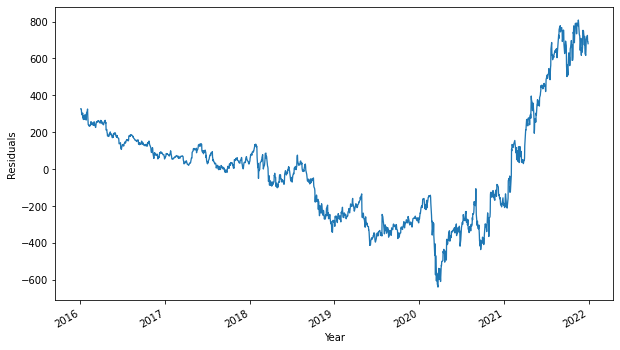

In [12]:
# Plot residuals
goog_res = fit_g.resid
plt.figure(figsize=(10, 6))
goog_res.plot(linewidth=1.3, xlabel="Year", ylabel="Residuals")
plt.show()

Notice that mean of residuals are <u> not </u> $0$ ($Var(\epsilon_i) \neq 0$) and residuals show trends.

From figure 3, we can see the residuals from the simple regression model with a trend variable does not appear to exhibit stationarity. The time series of residuals shows what resembles a "V pattern," and therefore, it does not appear that the mean is constant over time. Thus, the residuals from the regression do not form a stationary time series. 

Adding a trend variable does not seem to be enough to make Google stock price into a stationary time series.

Let's look at the differencing method.


### **2.2 Removing Trend Using the Differencing Method**

Another popular method to remove a trend in a time series is differencing. Before going into the differencing details, let's define some terms.

The first one we will introduce is first difference. First difference is defined as:

$$ \nabla x_{t} = x_{t} - x_{t-1} $$

And second difference can be written as:

$$ \nabla^{2} x_{t} = \nabla (\nabla x_t) = \nabla(x_{t}-x_{t-1}) = (x_{t}-x_{t-1}) - (x_{t-1}-x_{t-2}) $$

The next notation is backshift operator. The backshift operator is defined as:

$$ B x_{t} = x_{t-1} $$

And

$$ B^{2} x_{t} = B (B x_{t}) = B x_{t-1} = x_{t-2} $$

From above, we can write a general backshift operator as follows:

$$ B^{k} x_{t} = x_{t-k} $$

With the backshift operator, we can also write the first difference with backshift operator:

$$ \nabla x_{t} = x_{t}-x_{t-1} = x_{t}-Bx_{t} = (1-B)x_{t} $$

Then, the second difference can be defined and written as follows:

$$ \nabla ^{2} x_{t} = (1-B)^{2} x_{t} = (1-2B+B^{2}) x_{t} = x_{t} - 2 x_{t-1} + x_{t-2} $$

And the difference of order $d$ can be defined as:

$$ \nabla^{d} = (1-B)^{d} $$


The differencing method is used to generate first difference time series. Let's keep using Google stock price as an example. Figure 4 shows the first difference of Google stock price.


**Figure 4: First Difference of Google Stock Price**


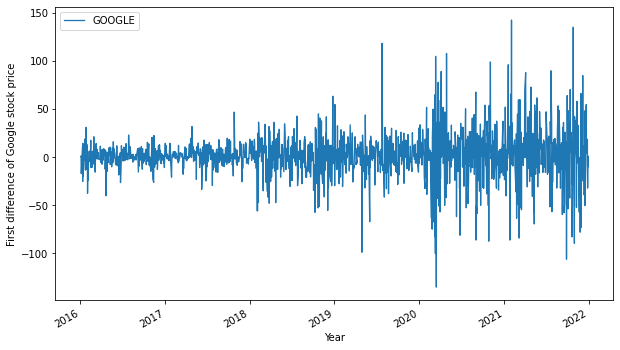

In [14]:
# Plot First Difference of Google Stock Price
goog.diff().plot(linewidth=1.3, xlabel="Year", ylabel="First difference of Google stock price", figsize=(10, 6))
plt.show()

We can see that the first difference of Google stock price fluctuates around $0$ during the whole period. However, the <u> variation of the first difference increases as time goes on. </u> It means that variance is dependent on time. Hence, the first differencing of Google stock price is still not enough to make it stationary. Let's look at its ACF.


**Figure 5: ACF of First Difference of Google Stock Price**

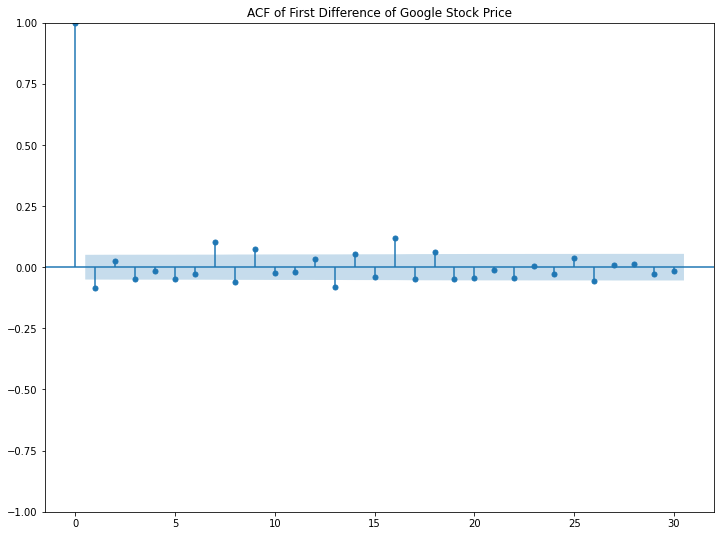

In [15]:
# ACF of First Difference of Google Stock Price
# (Note: [1:] as we need to skip first element since the model lost one data point)
fig, ax = plt.subplots(figsize=(12, 9))
sm.graphics.tsa.plot_acf(
    goog.diff()[1:],
    title="ACF of First Difference of Google Stock Price",
    lags=30,
    ax=ax,
)
plt.show()

From figure 5, we can see there are a few lags before lag 16 that are significant at the 95% level. We can use this piece of information for later modeling. 

We used both the trend variable and differencing methods to remove the trend for Google stock price time series. Unfortunately, neither method did a good job of converting the time series to a stationary one. In the following sections, we will learn more models to see if they would be a better model choice for Google stock price. 


## **3. White Noise**

**White noise** is a special time series model. The white noise time series is generated from a collection of uncorrelated random variables. We can define white noise time series ${W_{t}}$ as follows:

$$ {W_{t}}\sim WN(0,\sigma^{2}) $$

Its autocovariance is given by:

$$ \gamma_{_{W}}(h) = \begin{cases}
  \sigma_{2}  & \text{ for }  h=0 \\
  0  &  \text{ for } |h| \gt 0
\end{cases} $$

Since both mean and autocovariance of white noise are independent of $t$, white noise is a stationary time series.

If the white noise random variables are also independent and identical, we can denote it as follows:

$$ {W_{t}} \sim iid(0,\sigma^{2}) $$

If all the random variables are i.i.d. and normally distributed, this is a normal white noise time series and we can denote it as follows:

$$ {W_{t}} \sim iid N(0,\sigma^{2}) $$

Let's produce one simulation of a white noise process (see figure 6).
<span style='color: transparent; font-size:1%'>All rights reserved WQU WorldQuant University QQQQ</span>

**Figure 6: Normal White Noise Time Series Example**


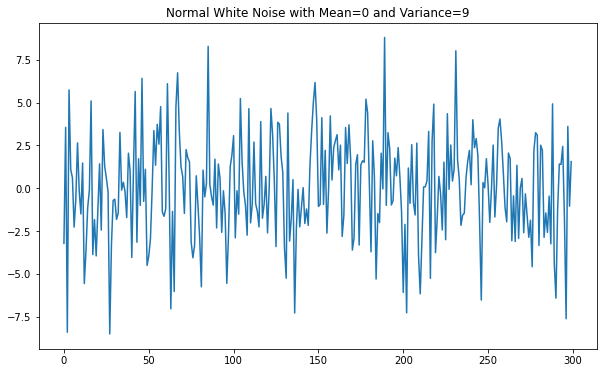

In [17]:
# Normal white noise ts example
plt.figure(figsize=(10, 6))
plt.plot(np.random.normal(0, 3, 300))
plt.title("Normal White Noise with Mean=0 and Variance=9")
plt.show()

Figure 6 shows a white noise time series with mean = $0$ and variance = $9$. We can see the time series is pretty choppy, but it oscillates around $0$. 

<u> Normal independent white noise is similar to the normal independent error terms $\epsilon_i$ in OLS regression. </u> 

Usually, a time series can be broken down into:

* a **trend component** such as drift $D$

* a **seasonality component**, 

* and a **residual component** such as $\epsilon_i$

If we can model the residual using a white noise model, then we will be able to model the whole time series and predict it. The random nature of the white noise makes it a good choice as a random term in the following time series models. 


## **4. Random Walk**

The next time series model we would like to talk about is the random walk time series. A random walk time series says that the current value depends only on the past value with a random component. We can write down the math definition as follows:

If $\{ X_{t} \}$ is a random walk time series and $x_0 = 0$, then $X_{t} = X_{t-1} + W_{t}$ where ${W_{t}} \sim WN(0,\sigma^{2})$

From the above definition, you can replace $X_{t_1}$ with $X_{t-2} + W_{t_1}$ and continue the same replacement process until $X$ is represented with $W_{i}$ where $i = 1, \cdots, t$ and $ X_{0}$. We call this a back substitution technique. After you do the process, you can replace the above definition with the following formula:

$$ X_{t} = \sum_{i=1}^{t} W_{i} + X_{0} = \sum_{i=1}^{t} W_{i} $$

The mean function:

$$  E(X_{t}) = E(X_{t-1} + W_{t}) = E(\sum_{i=1}^{t} W_{i} + X_{0}) = X_{0}=0 $$

From the mean function, we know it is not dependent on $t$ but on the first time $X_{0}$. In this case, it is $0$.

The autocovariance:

$$ COV(X_{t+h},X_{t}) = COV(X_{t} + W_{t+1} + W_{t+2} + \cdots + W_{t+h}, X_{t}) = Cov(X_{t},X_{t}) = t \delta^{2} $$

We can see the autocovariance is dependent on $t$. Hence, the random walk time series is not a stationary time series.


**Figure 7: Random Walk Examples**


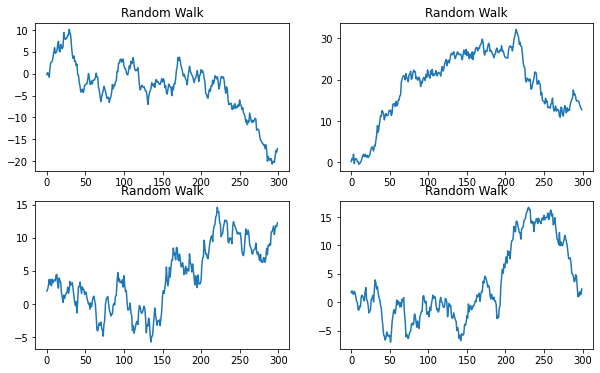

In [24]:
# Four random walks


# Helper function
def RandWalkPlot(seed):
    np.random.seed(seed)
    wn = np.random.normal(0, 1, 300)
    rw = np.cumsum(wn)
    plt.plot(rw)
    plt.title("Random Walk")


# 4 random walk examples
plt.figure(figsize=(10, 6))

ax1 = plt.subplot(221)
RandWalkPlot(12345)  # RW example 1

ax2 = plt.subplot(222)
RandWalkPlot(54321)  # RW example 2

ax3 = plt.subplot(223)
RandWalkPlot(222)  # RW example 3

ax4 = plt.subplot(224)
RandWalkPlot(333)  # RW example 4
plt.show()

In figure 7, we simulated four random walk time series of 300 data points with the same setup: normal white noise and $X_{0}=0$. Every time we generate a time series from the same random walk model, we'll get a very different random walk time series. There is no clear common pattern. We can also see random walk is not confined in a range as a stationary time series is. 

One common random walk time series variation is **random walk with a drift**. Random walk with a drift is to add a constant term $D$ to a random walk model. We can write random walk with a drift model as follows:

If $\{ X_t \}$ is a random walk with a drift time series and $x_{0} = 0$, then $X_{t} = D + X_{t-1} + W_{t}$ where ${W_{t}} \sim WN(0,\sigma^{2})$ and $D$ is a constant

We call $D$ a drift. With the back substitution technique, we can rewrite the model as follows:

$$ X_{t} = D t + \sum_{i=1}^{t} W_{i}+X_{0} = D t +\sum_{i=1}^{t} W_{i} $$

The mean function:

$$ E(X_{t}) = D t + \sum_{i=1}^{t} E(W_{i}) = D t $$

From the mean function, we see it is dependent on t.

The autocovariance:

$$ COV(X_{t+h},X_{t}) = COV(X_{t} + W_{t+1} + W_{t+2} + \cdots + W_{t+h}, X_{t}) = Cov(X_{t},X_{t}) = t \sigma^{2} $$

As the difference of random walk and random walk with a drift is only the addition of a constant drift, their autocovariance should be the same. We can see that random walk with a drift is not a stationary time series either. Both mean and autocovariance depend on $t$. Also because of the addition of drift, <u> the mean is increasing as time increases. </u> Hence, random walk with a drift is a choice to model real world time series that possess a trending pattern. 


**Figure 8: Random Walk with a Positive Drift and Random Walk with a Negative Drift Examples**


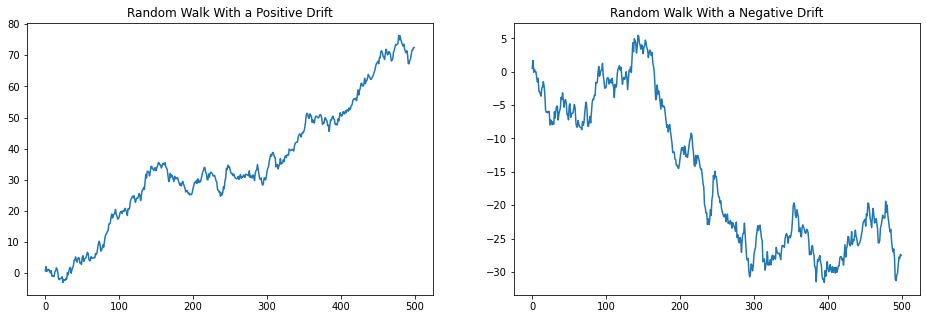

In [25]:
# RW examples with drift
np.random.seed(99999)
wnd = np.random.normal(0, 1, 500)

plt.figure(figsize=(16, 5))
ax1 = plt.subplot(121)
plt.plot(np.cumsum(wnd + 0.1))
plt.title("Random Walk With a Positive Drift")

ax2 = plt.subplot(122)
plt.plot(np.cumsum(wnd - 0.1))
plt.title("Random Walk With a Negative Drift")
plt.show()

In figure 8, we generated one random walk with a positive drift time series and one random walk with a negative drift time series. We can see the positive drift time series has a clear upward trend as expected. The negative drift time series initially goes up then slowly moves down but the pattern is very choppy. From the above graphs, random walk with a drift can be a model choice for a time series with a trending pattern.


## **5. Moving Average**

A moving average model tries to model a shock with impact in a finite time frame. If a shock in interest has an initial impact and the impact gradually fades in a finite time frame, the moving average model can be a model choice. A moving average with a shock lasting only for a total time range of $q$ can be written as MA($q$) and is defined as follows:

$$ W_{t} = W_{t} + \theta_{1} W_{t-1} + \theta_{2} W_{t-2} + \cdots + \theta_{q} W_{t-q} $$

Where $\theta_{1}, \theta_{2}, \cdots, \theta_{q}$ are parameters and $W_{t}$ is normally distributed white noise with mean = $0$ and variance $\sigma^{2}$ is $1$. There are $q$ lags in the model.

We can also write the MA($q$) model using backshift operator:

$$ X_{t} = \theta(B) W_{t} $$

Where $\theta(B)$ is the **moving average operator** as follows:

$$ \theta(B) = 1 + \theta_{1} B + \theta_{2} B^{2} + \cdots + \theta_{q} B^{q} $$

The following plots show some simulated examples for moving average models.
